# Boston Housing Prices

The objective of this workbook is to generate an optimal model based on statistical analysis with the tools available to estimate the best selling price for the client's home. Additional information on the Boston Housing dataset can be found [`here`](https://archive.ics.uci.edu/ml/datasets/Housing).

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pylab as pl
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd

#Libraries from Sci-kit Learn
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression

### Explore Data

In [13]:
#Load boston dataset
boston = datasets.load_boston()

#Values
housing_prices = boston.target #target values
housing_features = boston.data #attributes values

#Store in DataFrame
attributes = boston.feature_names #feature names
df_data = pd.DataFrame(housing_features, columns = attributes)
df_target = pd.DataFrame(housing_prices, columns =['MEDV'])
df_boston = pd.concat([df_data, df_target,], axis = 1) #concat data/target
print boston.DESCR

print "*****************************"
print "Summary\n"
feats = df_boston.shape[1]
obs = df_boston.shape[0]
print "Number of Housing Features: ", feats
print "Number of Houses: ", obs


Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### Statistical Analysis and Data Exploration

In [14]:
def histogram():
    X,y = housing_features, housing_prices
    pl.figure(figsize=(8,6))
    pl.hist(y, bins =20, color = 'blue',alpha=0.5)
    pl.suptitle('Boston Housing Prices', fontsize = 18)
    pl.xlabel('Housing Prices [$10k]', fontsize = 16)
    pl.ylabel('Frequency', fontsize = 16)
    pl.show()

In [15]:
def scatter_plots():
    pl.figure()
    fig,axes = pl.subplots(4, 4, figsize=(14,18))
    fig.subplots_adjust(wspace=.4, hspace=.4)
    img_index = 0
    for i in range(boston.feature_names.size):
        row, col = i // 4, i % 4
        axes[row][col].scatter(boston.data[:,i],boston.target)
        axes[row][col].set_title(boston.feature_names[i] + ' and MEDV')
        axes[row][col].set_xlabel(boston.feature_names[i])
        axes[row][col].set_ylabel('MEDV')
    pl.show()

In [16]:
def corrplot():
    fig, ax = pl.subplots(figsize=(10,10))
    pl.title("Correlation Plot",fontsize=16)
    sns.corrplot(df_boston)

In [19]:
# Calculate some Boston housing statistics:
def explore_city_data():
    number_houses = housing_features.shape[0] # size of data
    number_features = housing_features.shape[1] # number of features
    min_price = np.min(housing_prices) # minimum price
    max_price = np.max(housing_prices) # maximum price
    mean_price = np.mean(housing_prices) # mean price
    median_price = np.median(housing_prices)# median price
    std_price = np.std(housing_prices)# standard deviation
    
    print "Number of houses:", number_houses
    print "Number of features:", number_features
    print "Minimum Housing Price: ${:,.2f}".format(min_price)
    print "Maximum Housing Price: ${:,.2f}".format(max_price)
    print "Mean Housing Price: ${:,.2f}".format(mean_price)
    print "Median Housing Price: ${:,.2f}".format(median_price)
    print "Standard Deviation: ${:,.2f}".format(std_price)

In [20]:
def plot1():
    x = 'CRIM'
    y = 'LSTAT'
    x_label, y_label = x,y
    title = x + ' and '+ y
    create_plot(x,y,x_label,y_label,title)
    
def plot2():
    x = 'AGE'
    y = 'RM'
    x_label, y_label = x,y
    title = x + ' and '+ y
    create_plot(x,y,x_label,y_label,title)

def plot3():
    x = 'PTRATIO'
    y = 'TAX'
    x_label, y_label = x,y
    title = x + ' and '+ y
    create_plot(x,y,x_label,y_label,title)

def create_plot(x,y,x_label,y_label,title):
    hue = df_target
    df = df_data
    markerSize = df_target['MEDV']*6
    g = sns.lmplot(x=x,y=y,data=df,
               scatter_kws={'s':markerSize,'alpha':0.8,'linewidths':1,'edgecolor':'w'},
                   size=5.5, aspect=1.5)
    g.set_xlabels(x_label, size = 12)
    g.set_ylabels(y_label, size = 12)
    axes = g.axes
    sns.plt.title(title,fontsize=16)

***Statistics***

Number of houses: 506
Number of features: 13
Minimum Housing Price: $5.00
Maximum Housing Price: $50.00
Mean Housing Price: $22.53
Median Housing Price: $21.20
Standard Deviation: $9.19


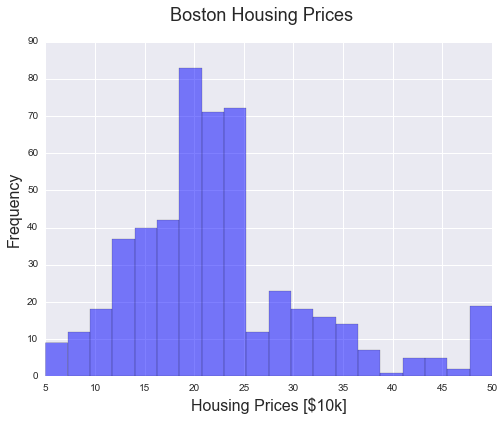

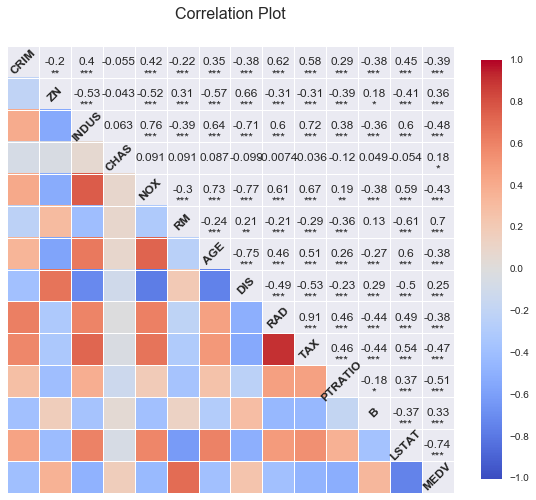

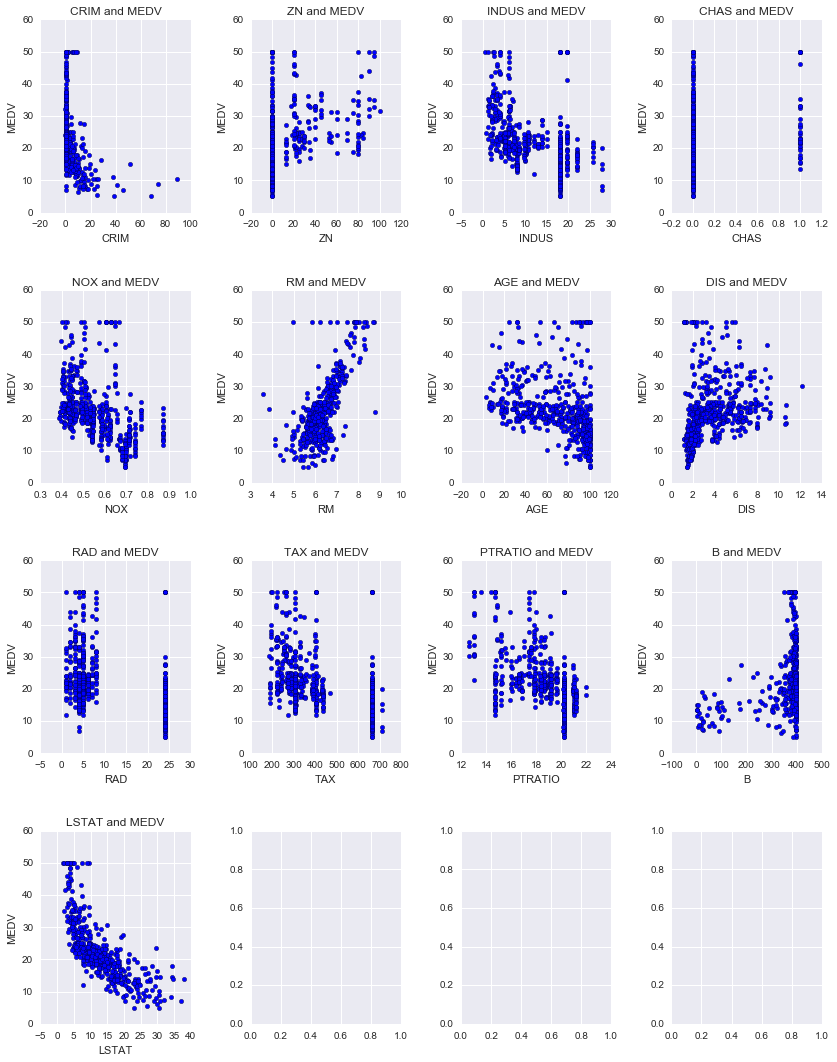


***Scatter Plots (Features)***


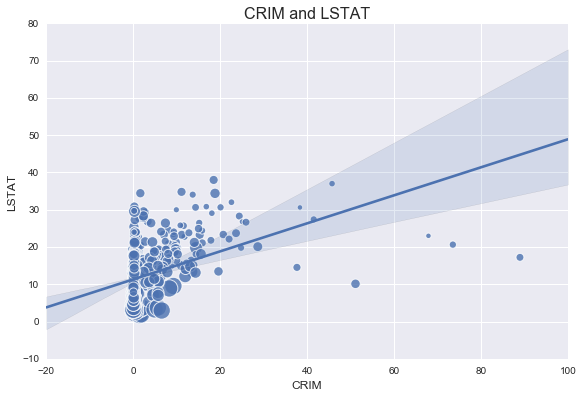

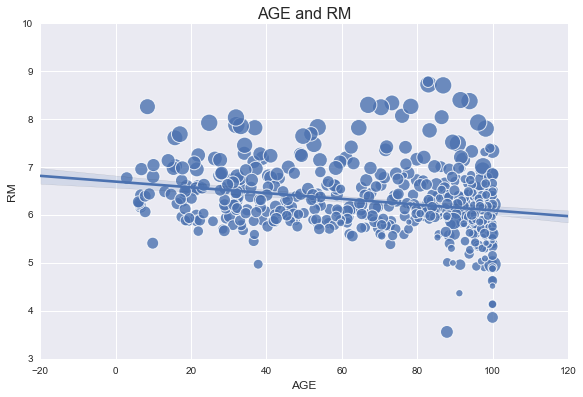

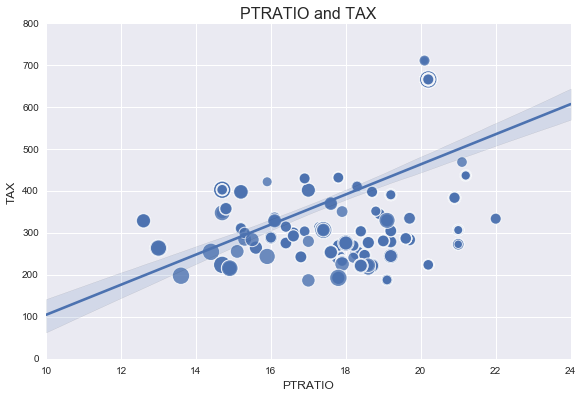

In [21]:
if __name__ == "__main__":   
    print "***Statistics***\n"
    explore_city_data()
    histogram()
    corrplot()
    scatter_plots()
    print "\n***Scatter Plots (Features)***"
    plot1()
    plot2()
    plot3()


### Splittling Training and Testing Data

In [22]:
def split_data():
    # Get the features and labels from the Boston housing data
    X, y = boston.data, boston.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=None)
    print "X_training:", X_train.shape
    print "X_test:", X_test.shape 
    return X_train, y_train, X_test, y_test

### Performance Metric: MSE

In [23]:
def performance_metric(label, prediction):
    """Calculates and returns the appropriate error performance metric."""
    #mae = mean_absolute_error(label, prediction)
    mse = mean_squared_error(label, prediction)
    return mse
    pass

## Linear Regression

In [25]:
def linear_regression():
    print "In progress..."
    
def main():
    linear_regression()

if __name__ == "__main__":
    main()

In progress...


## Regression Tree
Decision Trees are a non-parametric supervised learning method and can be used for regression. The here goal is to create a model that predicts the value of the Boston housing prices by learning simple decision rules inferred from the data features. The following blocks consists of code utilized to construct the learning curves, model complexity, and fitting the model.

### Learning Curve

In [12]:
depth = 5
def learning_curve(depth, X_train, y_train, X_test, y_test):
    """Calculate the performance of the model after a set of training data."""

    # We will vary the training set size so that we have 50 different sizes
    sizes = np.round(np.linspace(1, len(X_train), 50))
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    print "Decision Tree with Max Depth: "
    print (depth)

    for i, s in enumerate(sizes):

        # Create and fit the decision tree regressor model
        regressor = DecisionTreeRegressor(max_depth=depth)
        regressor.fit(X_train[:s], y_train[:s])

        # Find the performance on the training and testing set
        train_err[i] = performance_metric(y_train[:s], regressor.predict(X_train[:s]))
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))


    # Plot learning curve graph
    learning_curve_graph(sizes, train_err, test_err)


def learning_curve_graph(sizes, train_err, test_err):
    """Plot training and test error as a function of the training size."""
    pl.figure()
    pl.figure(figsize=(8,6))
    pl.title('Decision Trees: Performance vs Training Size', fontsize = 20)
    pl.plot(sizes, test_err, lw=2, label = 'test error')
    pl.plot(sizes, train_err, lw=2, label = 'training error')
    pl.legend()
    pl.xlabel('Training Size', fontsize = 14)
    pl.ylabel('Error', fontsize =14)
    pl.show()

X_training: (354, 13)
X_test: (152, 13)
Decision Tree with Max Depth: 
5


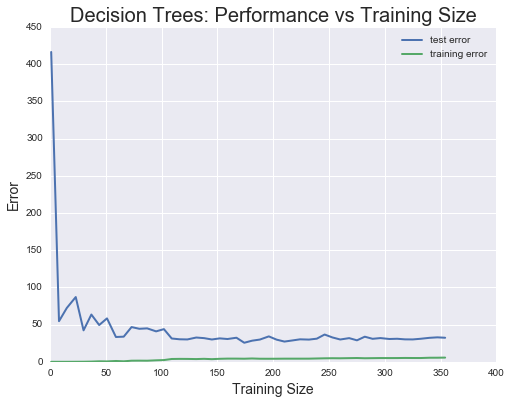

In [13]:
X_train, y_train, X_test, y_test = split_data()
learning_curve(depth, X_train, y_train, X_test, y_test)

### Model Complexity

In [14]:
def model_complexity(X_train, y_train, X_test, y_test):
    """Calculate the performance of the model as model complexity increases."""

    print "Model Complexity: "

    # We will vary the depth of decision trees from 2 to 25
    max_depth = np.arange(1, 25)
    train_err = np.zeros(len(max_depth))
    test_err = np.zeros(len(max_depth))

    for i, d in enumerate(max_depth):
        # Setup a Decision Tree Regressor so that it learns a tree with depth d
        regressor = DecisionTreeRegressor(max_depth=d)

        # Fit the learner to the training data
        regressor.fit(X_train, y_train)

        # Find the performance on the training set
        train_err[i] = performance_metric(y_train, regressor.predict(X_train))

        # Find the performance on the testing set
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))

    # Plot the model complexity graph
    model_complexity_graph(max_depth, train_err, test_err)


def model_complexity_graph(max_depth, train_err, test_err):
    """Plot training and test error as a function of the depth of the decision tree learn."""
    pl.figure()
    pl.title('Decision Trees: Performance vs Max Depth', fontsize = 20)
    pl.plot(max_depth, test_err, lw=2, label = 'test error')
    pl.plot(max_depth, train_err, lw=2, label = 'training error')
    pl.legend()
    pl.xlabel('Max Depth',fontsize =14)
    pl.ylabel('Error', fontsize =14)
    pl.show()

### Fit Model 

In [15]:
def fit_predict_model():

    # Get the features and labels from the Boston housing data
    
    X, y = boston.data, boston.target

    # Setup a Decision Tree Regressor
    
    regressor = DecisionTreeRegressor()
    
    parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
    
    mse_scoring = make_scorer(mean_squared_error, greater_is_better=False)
    
    #using grid search to fine tune the Decision Tree Regressor and
    #obtain the parameters that generate the best training performance. 

    reg = GridSearchCV(regressor, parameters, scoring = mse_scoring)
    reg.fit(X,y)
    
    # Fit the learner to the training data to obtain the best parameter set
    print "Final Model: "
    print (reg.fit(X, y))    

    # Using the model to predict the output of a particular sample
    x = [11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]
    x = np.array(x)
    x = x.reshape(1, -1)
    y = reg.predict(x)
    
    print "Best Parameters: ", reg.best_params_
    print "Best Estimator:", reg.best_estimator_
    print "Grid Score:", reg.grid_scores_
    print "\n"
    print "House: " + str(x)
    print "\n"
    print "Predicted: " + str(y)
    
    #DataFrame of Client_Features
    #x = [11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]
    #pd.DataFrame(zip(boston.feature_names, x), columns = ['Features', 'Client_Features'])
    

### Run Regression Tree Model

Decision Tree with Max Depth: 
1


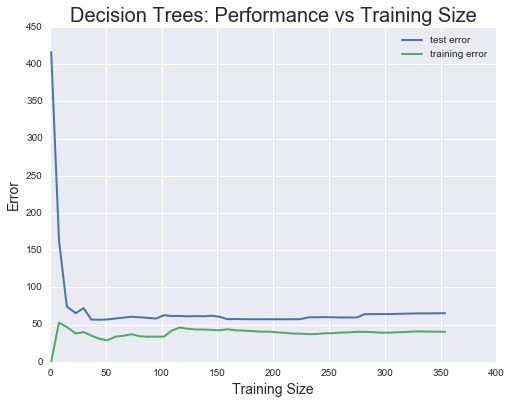

Decision Tree with Max Depth: 
2


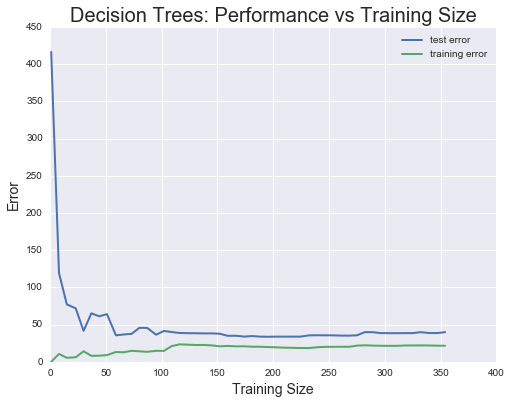

Decision Tree with Max Depth: 
3


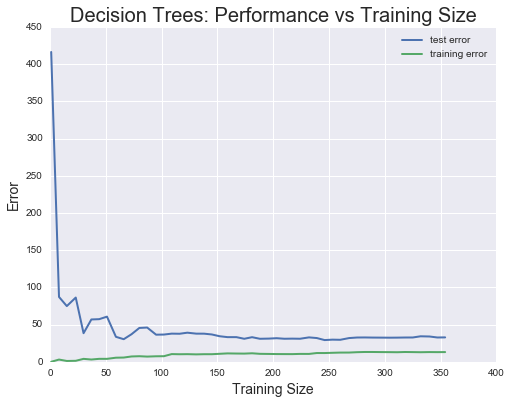

Decision Tree with Max Depth: 
4


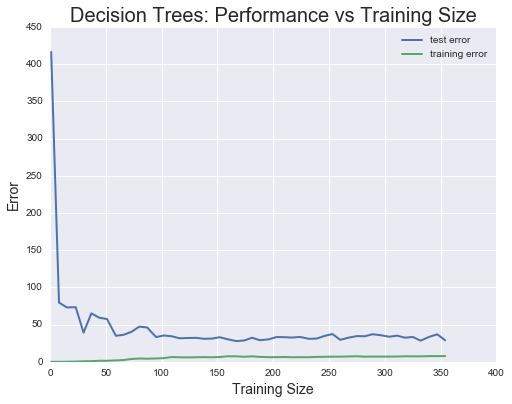

Decision Tree with Max Depth: 
5


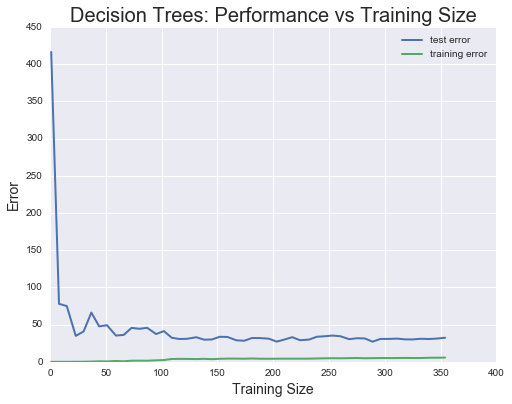

Decision Tree with Max Depth: 
6


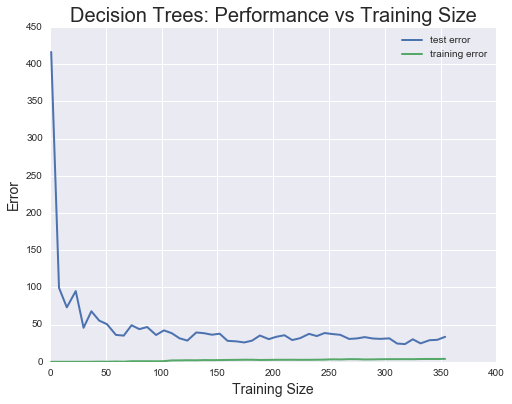

Decision Tree with Max Depth: 
7


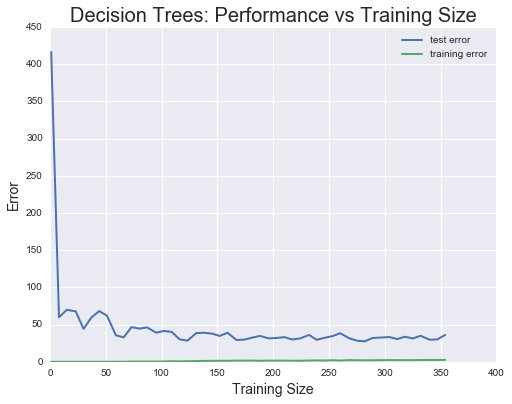

Decision Tree with Max Depth: 
8


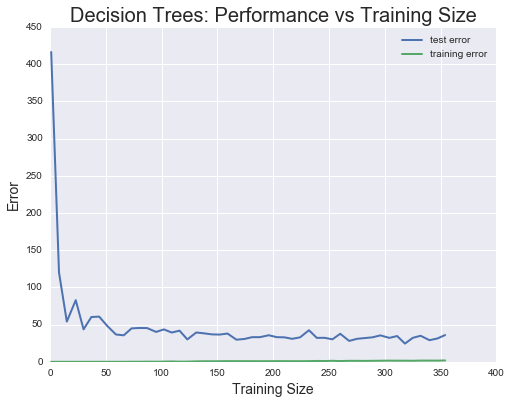

Decision Tree with Max Depth: 
9


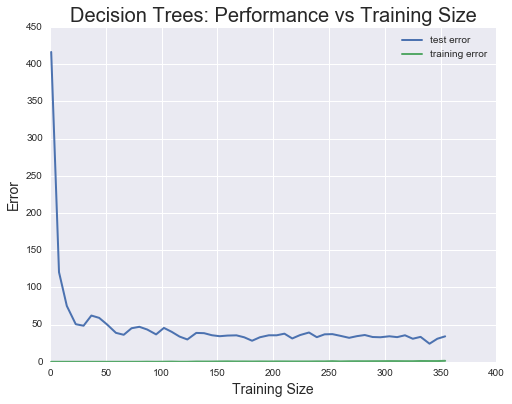

Decision Tree with Max Depth: 
10


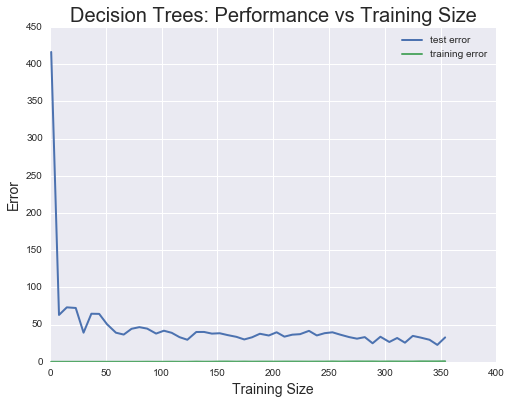

Model Complexity: 


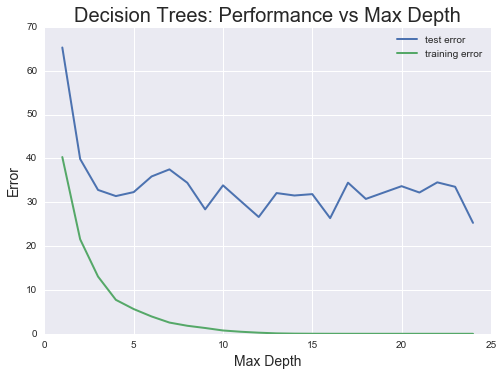

Final Model: 
GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)
Best Parameters:  {'max_depth': 4}
Best Estimator: DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
Grid Score: [mean: -68.08279, std: 25.52601, params: {'max_depth': 1}, mean: -46.72022, std: 21.02827, params: {'max_depth': 2}, mean:

In [16]:
def main():
    
    # Learning Curve Graphs
    max_depths = [1,2,3,4,5,6,7,8,9,10]
    for max_depth in max_depths:
        learning_curve(max_depth, X_train, y_train, X_test, y_test)
    
    # Model Complexity Graph
    model_complexity(X_train, y_train, X_test, y_test)

    #Tune and predict Model
    fit_predict_model()


if __name__ == "__main__":
    main()

In [17]:
def iterate_fit_predict():
    """Find and tune the optimal model. Make a prediction on housing data."""

    # Get the features and labels from the Boston housing data
    X, y = boston.data, boston.target

    # Setup a Decision Tree Regressor
    regressor = DecisionTreeRegressor()
  
    mse_scoring = make_scorer(mean_squared_error, greater_is_better=False)
    
    parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
    
    reg = GridSearchCV(regressor, parameters, scoring = mse_scoring, cv=3)

    # Fit the learner to the training data to obtain the best parameter set
    reg.fit(X, y)

    # Use the model to predict the output of a particular sample
    x = [11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]
    x = np.array(x)
    x = x.reshape(1, -1)
    y = reg.predict(x)
    
    return (reg.best_params_['max_depth'], y[0])

Iteration: Fit and Predict Model
    (GridSearchCV Results)

In [18]:
Grid_Search_Results = []

for i in range(100):
    Grid_Search_Results.append(iterate_fit_predict())

Grid_Search= np.asarray(Grid_Search_Results)
Grid_Search_Results_Depth = np.asarray(Grid_Search.T[0], dtype=int)
Grid_Search_Results_Price = np.asarray(Grid_Search.T[1], dtype=float)

Histogram: Maximum Depth (iterations = 100)

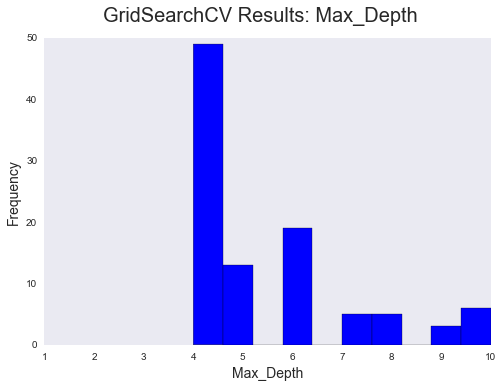

In [19]:
pl.hist(Grid_Search_Results_Depth, bins = 10, color = 'blue')
pl.suptitle("GridSearchCV Results: Max_Depth", fontsize = 20)
pl.xlabel("Max_Depth", fontsize = 14)
pl.ylabel("Frequency", fontsize = 14)
pl.xlim(1,10)
pl.grid()
pl.show()

Histogram: Predicted Housing Prices (iteraitons = 100)